<a href="https://colab.research.google.com/github/guthi1/deep-learning/blob/main/Assignment_1/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT6135-A2022
# Assignment 1: Practical

You must fill in your answers to various questions in this notebook, following which you must export this notebook to a Python file named `solution.py` and submit it on Gradescope.

Only edit the functions specified in the PDF (and wherever marked – `# WRITE CODE HERE`). Do not change definitions or edit the rest of the template, else the autograder will not work.

**Make sure you request a GPU runtime (especially for Question 3)!**

In [1]:
# DO NOT MODIFY!
import matplotlib.pyplot as plt
import numpy as np
import random

# Fix random seed
random.seed(0)
np.random.seed(0)

## Question 1: Implementing MLPs with NumPy (30 points)

In [2]:
class NN(object):
  """
    Implements an MLP.
  """

  def __init__(self,
               dims=(784, 128, 64, 10), # h_0, h_1, h_2, h_3
               activation="relu",       # Activation function
               epsilon=1e-6,            # Correction factor
               lr=0.01,                 # Learning rate
               seed=0                   # Random seed
              ):
    """
      Constructor of the NN class.

      dims: list or tuple or np.array, default (784, 128, 64, 10)
        Values of h_0 (no. of features), h_1 (hidden dim. 1), h_2 (hidden dim. 2), h_3 (no. of output classes).
      activation: string, default "relu"
        Activation function to use.
      epsilon: float or double, default 1e-6
        Correction factor to clip probabilities.
      lr: float or double, default 0.01
        Learning rate for weight updates.
      seed: int, default 0
        Random seed.
    """
    super(NN, self).__init__()

    self.dims = dims
    self.n_hidden = len(dims) - 2
    self.activation_str = activation
    self.epsilon = epsilon
    self.lr = lr
    self.seed = seed
    self.debug = False

  def initialize_weights(self):
    """
      Results: Initializes the weights of the MLP from uniform(-1/sqrt(h_0), 1/sqrt(h_0)) and the biases to zeros.
    """
    if self.seed is not None:
      np.random.seed(self.seed)

    self.weights = {}
    # self.weights is a dictionary with keys W1, b1, W2, b2, ..., Wm, Bm where m - 1 is the number of hidden layers
    # The keys W1, W2, ..., Wm correspond to weights while b1, b2, ..., bm correspond to biases
    for layer_n in range(1, self.n_hidden + 2):
      """ h_0 = nb. feature input data """
      h_0 = self.dims[0]

      """ Number of weight of a layer """
      n_weights = self.dims[layer_n-1] * (self.dims[layer_n])

      """ Init the weight """
      weights = np.random.uniform(-1/np.sqrt(h_0), 1/np.sqrt(h_0), size=n_weights)

      """ Reshape in the good size
      " | W_00  W_01 .. |
      " | W_10  W_11 .. |
      " |  ..    ..  .. | 
      """
      weights = np.reshape(weights, (self.dims[layer_n-1], self.dims[layer_n]))

      """ Weights : matrix of shape(n_neurone{layer_i}, n_neuro{layer_i-1}) """
      self.weights[f"W{layer_n}"] = weights
      self.weights[f"b{layer_n}"] = np.zeros((1, self.dims[layer_n]))

  def relu(self, x, grad=False):
    """
      x: np.array
        Inputs to calculate ReLU(x) for. x may contain a batch of inputs!
      grad: bool, default False
        If True, return the gradient of the activation with respect to the inputs to the function.

      Outputs: Implements the ReLU activation function or its gradient.
    """
    if grad:
      x[x <= 0] = 0
      x[x > 0] = 1
      return x
    return np.maximum(0, x)

  def sigmoid(self, x, grad=False):
    """
      x: np.array
        Inputs to calculate sigmoid(x) for. x may contain a batch of inputs!
      grad: bool, default False
        If True, return the gradient of the activation with respect to the inputs to the function.

      Outputs: Implements the Sigmoid activation function or its gradient.
    """
    def sigmoid(x):
        return 1/(1+np.exp(-x))

    if grad:
      return sigmoid(x)*(1-sigmoid(x))
    return sigmoid(x)

  def tanh(self, x, grad=False):
    """
      x: np.array
        Inputs to calculate tanh(x) for. x may contain a batch of inputs!
      grad: bool, default False
        If True, return the gradient of the activation with respect to the inputs to the function.

      Outputs: Implements the tanh activation function or its gradient.
    """
    def tanh(x):
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

    if grad:
      return 1-(np.power(tanh(x), 2))
    return tanh(x)

  def activation(self, x, grad=False):
    """
      x: np.array
        Inputs to calculate activation(x) for. x may contain a batch of inputs!
      grad: bool, default False
        If True, return the gradient of the activation with respect to the inputs to the function.

      Outputs: Returns the value of the activation or the gradient.
    """
    if self.activation_str == "relu":
      return self.relu(x, grad=grad) 
    elif self.activation_str == "sigmoid":
      return self.sigmoid(x, grad=grad)
    elif self.activation_str == "tanh":
      return self.tanh(x, grad=grad)
    else:
      raise Exception("Invalid activation")
    return 0

  def softmax(self, x):
    """
      x: np.array
        Inputs to calculate softmax over. x may contain a batch of inputs!

      Outputs: Implements the softmax function, returns the array containing softmax(x).
    """
    axis = 1
    max = np.max(x, axis=axis)
    exp_x = np.exp(x - np.expand_dims(max, axis))
    sum = np.sum(exp_x, axis=axis)
    return exp_x / np.expand_dims(sum, axis)

  def forward(self, x):
    """
      x: np.array
        Inputs to the MLP. Note that x may contain multiple input examples, not just one example.

      Outputs: Implements the forward pass, returns cache as described below.
    """
    cache = {"Z0": x}
    # cache is a dictionary with keys Z0, A1, Z1, ..., Am, Zm where m - 1 is the number of hidden layers
    # Z0 just contains the inputs x to the network
    # Ai corresponds to the preactivation at layer i, Zi corresponds to the activation at layer i
    if self.debug:print("\nFoward ...")
    z = x

    for layer_n in range(1, self.n_hidden + 2):

        # Get the weiths
        weights = self.weights[f"W{layer_n}"]
        bias = self.weights[f"b{layer_n}"]

        # Calcul       
        if self.debug:print(f"layer_{layer_n}")
        if self.debug:print(f"    z_{z.shape} dot w_{weights.shape} + b_{bias.shape}")
        # Do calcul
        a = z.dot(weights) + bias
        
        if layer_n == self.n_hidden+1:
            z = self.softmax(a)
        else:
            z = self.activation(a)
        if self.debug:print(f"    = z_{z.shape}")
    
        # Save value
        cache[f"A{layer_n}"] = a
        cache[f"Z{layer_n}"] = z
    
    return cache

  def loss(self, prediction, labels):
    """
      prediction: np.array
        Predicted probabilities for each class for inputs. May contain multiple examples (a batch)!
      labels: np.array
        True labels corresponding to the inputs (assume they are one-hot encoded). May contain multiple examples (a batch)!

      Outputs: Returns the crossentropy loss (take the mean over number of inputs).
    """
    prediction[np.where(prediction < self.epsilon)] = self.epsilon
    prediction[np.where(prediction > 1 - self.epsilon)] = 1 - self.epsilon
    return (- np.sum(labels * np.log(prediction))) / len(prediction)

  def backward(self, cache, labels):
    """
      cache: np.array
        Results of the backward pass. This may be for multiple examples (a batch).
      labels: np.array
        True labels corresponding to the inputs in cache. May contain multiple examples (a batch)!

      Outputs: Implements the backward pass, returns grads as described below.
    """
    output = cache[f"Z{self.n_hidden + 1}"]
    grads = {}

    # grads is a dictionary with keys dAm, dWm, dbm, dZ(m-1), dA(m-1), ..., dW1, db1
    # Remember to account for the number of input examples!

    """
    We need to find: dC/dw et dC/db. For that, let introduce intermediate quantity
    delta_l: [] vector of errors associated with neuron in layer l
        -> delta_l = dC/ da
        -> Come from activation(a_l + little_delta)
        -> delta_l = dC/dz_l = activation'(a_l)
    """
    if self.debug:print("\nBackward ...")
    
    # Last layer
    """ delta_L = nabla Hadamard_product act_func_derivative(w_L * h_L-1 + b) """
    delta = (output - labels) # softmax cross_entropy backward    
    if self.debug:print(f"      delta_{delta.shape}")

    # Save value
    grads[f"db{self.n_hidden + 1}"] = np.expand_dims(np.mean(delta, axis=0), axis=0)
    grads[f"dA{self.n_hidden + 1}"] = delta

    """ dC/dw_L = h_L-1 * delta_L """
    z_in = cache[f"Z{self.n_hidden}"]
    partial_derivatire = np.dot(z_in.T, delta) / z_in.shape[0]
    # Save value
    grads[f"dW{self.n_hidden + 1}"] = partial_derivatire

    # From here, we need to apply the chain rule -  Loop backward
    for layer_n in range(self.n_hidden, 0, -1):
        """ delta_l = ((w_l+1).T * delta_l+1) element_wise_mul act_func_derivative(w_l * z_l-1 + b) """
        a = cache[f"A{layer_n}"]
        activation_back = self.activation(a, grad=True)

        # Find error (delta) for the current layer
        weights_next = self.weights[f"W{layer_n+1}"]  
        if self.debug:print(f"      delta_pre_act = weight_{weights_next.T.shape} * delta_{delta.shape}")  
        delta_pre_act = np.dot(delta, weights_next.T)
        grads[f"dA{layer_n}"] = delta_pre_act

        # error * activation_back
        if self.debug:print(f"      delta_ = delta_pre_act_{delta_pre_act.shape} * activation_back_{activation_back.shape}")
        delta = delta_pre_act * activation_back
        grads[f"dZ{layer_n}"] = delta

        grads[f"db{layer_n}"] = np.expand_dims(np.mean(delta, axis=0), axis=0)

        """ dC/dw_l = z_l-1 * delta_l """
        z_in = cache[f"Z{layer_n-1}"]
        # partial_derivatire = z_in_(5, 64).T * delta_(5, 10)
        partial_derivatire = np.dot(z_in.T, delta) / z_in.shape[0]

        grads[f"dW{layer_n}"] = partial_derivatire

    return grads

  def update(self, grads):
    """
      grads: np.dictionary
        Gradients obtained from the backward pass.

      Results: Updates the network's weights and biases.
    """
    if self.debug:print(f"\nUpdate ... ~~~~~~~~~~~~~~~~")
    for layer in range(1, self.n_hidden + 2):
        # WRITE CODE HERE
        if self.debug:print(f"layer_{layer}")

        grad = grads[f"dW{layer}"]
        weights = self.weights[f"W{layer}"]
        if self.debug:print(f"   weights_{weights.shape} - lr * grad_{grad.shape}")
        weights = weights - self.lr * grad
        self.weights[f"W{layer}"] = weights

        bias_up = grads[f"db{layer}"]
        bias = self.weights[f"b{layer}"]
        if self.debug:print(f"   weights_{bias.shape} - lr * bias_up_{bias_up.shape}")
        bias = bias - self.lr * bias_up
        self.weights[f"b{layer}"] = bias

In [3]:
class Data_loader():
    def __init__(self, batch_size=5):
        self.batch_size = batch_size
        self.data = dict()
        for i in range(10):
            X = np.random.normal(loc=i/2, scale=i/4, size=(30, 784))
            labels = np.zeros(10)
            labels[i] = 1
            self.data[i] = (X, labels)

    def next(self):
        batch_X = []
        batch_y = []
        for i in range(self.batch_size):
            k = np.random.choice(list(self.data.keys()))
            j = np.random.choice(len(self.data[k][0]))
            batch_X.append(self.data[k][0][j])
            batch_y.append(self.data[k][1]) 
        return np.array(batch_X), np.array(batch_y)

In [4]:
""" Dummy exemple for testing """
# Param
training_loop = 100
batch_size = 5

# Data
data_load = Data_loader(batch_size)

# MLP
nn = NN()
nn.debug = False
nn.initialize_weights()

for _ in range(training_loop):
    X, y = data_load.next()
    res = nn.forward(X)
    output = res["Z3"]
    loss = nn.loss(output, y)
    print(loss)
    grads = nn.backward(res, y)

    nn.update(grads)

X, y = data_load.next()
res = nn.forward(X)
output = res["Z3"]
print(y)
np.argmax(output, axis=1)


2.2908272414344246
2.268255902805762
2.3009746519694376
2.275502496577709
2.31179466386292
2.2772327212067083
2.32234764966615
2.28784128416965
2.2930451029077545
2.3124080484580647
2.2723494250557303
2.3073098795637015
2.27608395997915
2.273900044673095
2.26851157805561
2.277956745887944
2.271445374662251
2.2725385848048
2.3059788929908813
2.2452957212575653
2.2633332426183186
2.247602482663675
2.301969176719724
2.1917290640173563
2.224185805514165
2.1399191684385475
2.2644845109929994
2.2832026506513055
2.2944590145740333
2.251659639357002
2.2175193371693402
2.1826301849296628
2.141271458925128
2.270107701952676
2.345815323596416
2.0974523664867912
2.2400911625445104
2.2708550885208845
2.3565495734323583
2.2401612437589544
2.0714686483017006
1.991235731004868
2.3572550338553713
1.9368873604921906
2.332495529019637
2.045138306685486
2.018839965708838
2.0035042210560903
2.10733281259203
2.38006711517105
2.3429465561075267
2.36459169974369
2.058700802344566
2.0772891234930126
2.13354261

array([9, 9, 9, 9, 9])

In [5]:
""" Dummy exemple for testing """

x = np.random.rand(5, 784)
labels = np.zeros((5, 10))
labels[:,:1] = 1
print(labels)
nn = NN()
nn.debug = True
nn.initialize_weights()

for p in nn.weights.keys():
    print(f"{p}: {nn.weights[p].shape}")
res = nn.forward(x)
output = res["Z3"]
training_loop = 1
loss = nn.loss(output, labels)

for _ in range(training_loop):
    res = nn.forward(x)
    output = res["Z3"]
    loss = nn.loss(output, labels)

    grads = nn.backward(res, labels)

    print(f"Backprop res")
    for it in grads.keys():
        print(f"{it}: {grads[it].shape}")

    nn.update(grads)

res = nn.forward(x)
output = res["Z3"]

np.argmax(output, axis=1)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
W1: (784, 128)
b1: (1, 128)
W2: (128, 64)
b2: (1, 64)
W3: (64, 10)
b3: (1, 10)

Foward ...
layer_1
    z_(5, 784) dot w_(784, 128) + b_(1, 128)
    = z_(5, 128)
layer_2
    z_(5, 128) dot w_(128, 64) + b_(1, 64)
    = z_(5, 64)
layer_3
    z_(5, 64) dot w_(64, 10) + b_(1, 10)
    = z_(5, 10)

Foward ...
layer_1
    z_(5, 784) dot w_(784, 128) + b_(1, 128)
    = z_(5, 128)
layer_2
    z_(5, 128) dot w_(128, 64) + b_(1, 64)
    = z_(5, 64)
layer_3
    z_(5, 64) dot w_(64, 10) + b_(1, 10)
    = z_(5, 10)

Backward ...
      delta_(5, 10)
      delta_pre_act = weight_(10, 64) * delta_(5, 10)
      delta_ = delta_pre_act_(5, 64) * activation_back_(5, 64)
      delta_pre_act = weight_(64, 128) * delta_(5, 64)
      delta_ = delta_pre_act_(5, 128) * activation_back_(5, 128)
Backprop res
db3: (1, 10)
dA3: (5, 10)
dW3: (64, 10)
dA2

array([8, 8, 4, 8, 4])

## Question 2: Implementing CNN layers with NumPy (20 points)
Note: You may assume that there are no biases, no input padding (valid convolution) and also that convolution here refers to cross-correlation, i.e., no kernel flipping when convolving the inputs.

In [75]:
class Convolution2dLayer(object):
  """
    Implements a 2D convolution layer.
  """

  def __init__(self, filter_size=3, stride=1, n_units=64, seed=0):
    """
      Constructor of the Convolution2dLayer class.

      Note: We assume that the input images have only a single channel.

      filter_size: int, default 3
        Filter size to use for convolution. We assume equal height and width.
      stride: int, default 1
        Stride for convolution.
      n_units: int, default 64
        Number of output channels, i.e., number of filters in the layer.
      seed: int, default 0
        Random seed.
    """
    super(Convolution2dLayer, self).__init__()

    self.filter_size = filter_size
    self.stride = stride
    self.n_units = n_units
    self.seed = seed

  def initialize_weights(self):     
    """
      Results: Initializes the weights of the CNN from uniform(0, 1).
    """   
    if self.seed is not None:
      np.random.seed(self.seed)

    # self.weights is an np.array of shape (n_units, filter_size, filter_size)
    # We do not consider biases in this convolution layer implementation
    # WRITE CODE HERE
    self.weights = np.random.uniform(0, 1, (self.n_units, self.filter_size, self.filter_size))

  def forward(self, x):
    """
      x: np.array
        Inputs to convolve. This may contain multiple input examples, not just one.
        Note: We assume that the input images have only a single channel, e.g. (5, 1, 32, 32) where 5 is the number of
        images, 1 channel, 32x32 image size.

      Outputs: Inputs and the result of the convolution operation on the inputs stored in cache.

      Note: You need not flip the kernel! You may just implement cross-correlation.
    """
    cache = {}

    # cache is a dictionary where cache["x"] stores the inputs and cache["out"] stores the outputs of the layer
    # WRITE CODE HERE
    cache["x"] = x
    cache["out"] = None

    # Fin output size
    nb_img, channel, dim_x_img, dim_y_img = x.shape
    dim_out = (dim_x_img-self.filter_size)//self.stride + 1
    output = np.zeros((nb_img, self.n_units, dim_out, dim_out))

    """ This oculd be speed up with matrix multiplication ... """
    # For each image
    for img_idx in range(nb_img):
        # For each filter
        for n_idx in range(self.n_units):
            # Apply kernel
            img = x[img_idx, 0]
            for i in range(0, dim_out, self.stride):
                for j in range(0, dim_out, self.stride):
                    # Select part of the img
                    img_patch = img[i:i+self.filter_size, j:j+self.filter_size]
                    # select kernel
                    kernel = self.weights[n_idx]
                    # Apply kernel
                    kernel_output = np.multiply(img_patch, kernel)
                    kernel_output = np.sum(kernel_output)
                    # Save output
                    output[img_idx, n_idx, i, j] = kernel_output
    cache["out"] = output
    return cache

  def backward(self, cache, grad_output):
    """
      cache: dictionary
        Contains the inputs and the result of the convolution operation applied on them.
      grad_output: np.array
        Gradient of the loss with respect to the outputs of the convolution layer.

      Outputs: Gradient of the loss with respect to the parameters of the convolution layer.
    """
    # grads is an np.array containing the gradient of the loss with respect to the parameters in the convolution layer
    # Remember to account for the number of input examples!
    # WRITE CODE HERE
    grads = None
    pass
    return grads


class MaxPooling2dLayer(object):
  """
    Implements a 2D max-pooling layer.
  """

  def __init__(self, filter_size=2):
    """
      Constructor of the MaxPooling2dLayer class.

      filter_size: int, default 2
        Filter size to use for max-pooling. We assume equal height and width, and stride = height = width.
    """
    super(MaxPooling2dLayer, self).__init__()
  
    self.filter_size = filter_size
    self.stride = filter_size

  def forward(self, x):
    """
      x: np.array
        Inputs to compute max-pooling for. This may contain multiple input examples, not just one.
        Note: The input dimensions to max-pooling are the output dimensions of the convolution!

      Outputs: Inputs and the result of the max-pooling operation on the inputs stored in cache.
    """
    cache = {}

    # cache is a dictionary where cache["x"] stores the inputs and cache["out"] stores the outputs of the layer
    # WRITE CODE HERE
    cache["x"] = x
    cache["out"] = None

    # Fin output size
    nb_img, channel, dim_x_img, dim_y_img = x.shape
    dim_out = (dim_x_img)//self.stride
    output = np.zeros((nb_img, channel, dim_out, dim_out))

    """ This could be speed up with matrix multiplication ... """
    # For each image
    for img_idx in range(nb_img):
        # For each filter
        for channel_idx in range(channel):
            # Apply kernel
            img = x[img_idx, channel_idx]
            for i in range(0, dim_out):
                for j in range(0, dim_out):
                    # Select part of the img
                    loc_i = i*self.stride
                    loc_j = j*self.stride
                    img_patch = img[loc_i:loc_i+self.filter_size, loc_j:loc_j+self.filter_size]
                    # Save output
                    output[img_idx, channel_idx, i, j] = np.max(img_patch)
    cache["out"] = output

    return cache

  def backward(self, cache, grad_output):
    """
      cache: dictionary
        Contains the inputs and the result of the max-pooling operation applied on them.
      grad_output: np.array
        Gradient of the loss with respect to the outputs of the max-pooling layer.

      Outputs: Gradient of the loss with respect to the inputs to the max-pooling layer.
    """
    grads = None # WRITE CODE HERE (initialize grads correctly)

    # grads is an np.array containing the gradient of the loss with respect to the inputs to the max-pooling layer
    # Remember to account for the number of input examples!
    # WRITE CODE HERE
    pass
    return grads

[[[[2.04863103 1.86755507 2.57819173 4.44529977 3.6863929  0.02576482]
   [3.47078926 4.59753703 3.5522788  0.88502891 2.41759064 0.70158009]
   [1.79497639 4.68558521 4.61652654 1.41418426 1.69815522 3.00106434]
   [4.81598648 0.73900667 1.28458322 4.36778414 2.45946116 4.49480546]
   [0.92758949 2.66334294 1.63134816 1.5827128  2.23438482 2.16538725]
   [1.7867344  4.57485385 3.65872093 3.63773496 1.44956725 2.88854712]]

  [[3.89589717 3.97795184 1.7226523  3.85436378 3.67946948 0.70753243]
   [4.32972734 2.20660735 2.43205224 2.24184589 2.83923001 3.10584624]
   [2.49089783 4.33394272 3.13867378 2.00713975 2.08345878 4.05419308]
   [1.74095971 1.05727398 0.29691594 4.38013424 4.59273226 0.60060091]
   [1.67236871 0.87686035 0.57949234 4.49933372 0.2843863  4.90242832]
   [0.4822543  4.31735325 2.83253053 1.83958744 1.71171188 3.78682072]]]]


array([[[[4.59753703, 4.44529977, 3.6863929 ],
         [4.81598648, 4.61652654, 4.49480546],
         [4.57485385, 3.65872093, 2.88854712]],

        [[4.32972734, 3.85436378, 3.67946948],
         [4.33394272, 4.38013424, 4.59273226],
         [4.31735325, 4.49933372, 4.90242832]]]])

In [ ]:
print()

In [7]:
conv3x3 = Convolution2dLayer(n_units=2)
conv3x3.initialize_weights()

imgs = np.random.uniform(1, 2,(1,1,10,10))

out = conv3x3.forward(imgs)

for k in out.keys():
    print(f"{k}: {out[k].shape}")

maxPooling = MaxPooling2dLayer()
out = maxPooling.forward(imgs)
for k in out.keys():
    print(f"{k}: {out[k].shape}")

x: (1, 1, 10, 10)
out: (1, 2, 8, 8)
x: (1, 1, 10, 10)
out: (1, 1, 5, 5)


## Question 3: Implementing a CNN and comparison with MLPs using PyTorch (50 points)

In [8]:
# DO NOT MODIFY!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seed
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
# from unittest import TestCase
# TestCase.maxDiff = None

class ResidualBlock(nn.Module):
  """This class implements the Residual Block used in ResNet-18."""

  def __init__(self, in_channels, channels, conv_stride=1, activation_str="relu", initialization="xavier_normal"):
    """
      Constructor for the ResidualBlock class.

      in_channels: int
        Number of channels in the input to the block.
      channels: int
        Number of output channels for the block, i.e., number of filters.
      conv_stride: int, default 1
        Stride of the first convolution layer and downsampling convolution (if required).
      activation_str: string, default "relu"
        Activation function to use.
      initialization: string, default "xavier_normal"
        Initialization for convolution layer weights.
    """
    super(ResidualBlock, self).__init__()

    self.in_channels = in_channels
    self.channels = channels
    self.conv_stride = conv_stride
    self.activation_str = activation_str
    self.initialization = initialization

    # Define these members by replacing `None` with the correct definitions
    self.conv1 = nn.Conv2d(in_channels, channels, 3, stride=conv_stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(channels)
    self.conv2 = nn.Conv2d(channels, channels, 3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(channels)

    self.residual_connection = self.residual(in_channels, channels, conv_stride)

    # Initialize weights for conv1 and conv2
    if initialization == "xavier_normal":
      nn.init.xavier_normal_(self.conv1.weight)
      nn.init.xavier_normal_(self.conv2.weight)
    elif initialization == "xavier_uniform":
      nn.init.xavier_uniform_(self.conv1.weight)
      nn.init.xavier_uniform_(self.conv2.weight)
    elif initialization == "kaiming_normal":
      nn.init.kaiming_normal_(self.conv1.weight)
      nn.init.kaiming_normal_(self.conv2.weight)
    else:
      raise Exception("Invalid initialization")

  def activation(self, input):
    """
      input: Tensor
        Input on which the activation is applied.

      Output: Result of activation function applied on input.
        E.g. if self.activation_str is "relu", return relu(input).
    """
    if self.activation_str == "relu":
      return torch.relu(input)
    elif self.activation_str == "tanh":
      return torch.tanh(input)
    else:
      raise Exception("Invalid activation")

  def residual(self, in_channels, channels, conv_stride=1):
    """
      in_channels: int
        Number of input channels in the input to the block.
      channels: int
        Number of output channels for the block, i.e., number of filters.
      conv_stride: int, default 1
        Stride to use for downsampling 1x1 convolution.

      Output: Returns an nn.Sequential object which computes the identity function of the input if stride is 1
              and the number of input channels equals the number of output channels. Otherwise, it returns an
              nn.Sequential object that downsamples its input using a 1x1-conv of the stride specified and
              followed by a BatchNorm2d.
    """
    layers = []
    if conv_stride != 1 or in_channels != channels:
      layers.append(nn.Conv2d(in_channels, channels, 1, stride=conv_stride, padding=0, bias=False))
      layers.append(nn.BatchNorm2d(channels))
    return nn.Sequential(*layers)

  def forward(self, x):
    """
      x: Tensor
        Input to the block.

      Outputs: Returns the output of the forward pass of the block.
    """
    # WRITE CODE HERE
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.activation(out)

    out = self.conv2(out)
    out = self.bn2(out)

    out += self.residual_connection(identity)
    out = self.activation(out)

    return out

In [10]:
class ResNet18(nn.Module):
  """This class implements the ResNet-18 architecture from its components."""

  def __init__(self, activation_str="relu", initialization="xavier_normal"):
    """
      Constructor for the ResNet18 class.

      activation_str: string, default "relu"
        Activation function to use.
      initialization: string, default "xavier_normal"
        Weight initialization to use.
    """
    super(ResNet18, self).__init__()

    self.n_classes = 10
    self.activation_str = activation_str
    self.initialization = initialization

    # Define these members by replacing `None` with the correct definitions
    self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._create_layer(64, 64) 
    self.layer2 = self._create_layer(64, 128, conv_stride=2)
    self.layer3 = self._create_layer(128, 256, conv_stride=2)
    self.layer4 = self._create_layer(256, 512, conv_stride=2)  
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.linear = nn.Linear(512, 10)
  
  def activation(self, input):
    """
      input: Tensor
        Input on which the activation is applied.

      Output: Result of activation function applied on input.
        E.g. if self.activation_str is "relu", return relu(input).
    """
    if self.activation_str == "relu":
      return torch.relu(input)
    elif self.activation_str == "tanh":
      return torch.tanh(input)
    else:
      raise Exception("Invalid activation")

  def _create_layer(self, in_channels, channels, conv_stride=1):
    """
      in_channels: int
        Number of input channels present in the input to the layer.
      out_channels: int
        Number of output channels for the layer, i.e., the number of filters.
      conv_stride: int, default 1
        Stride of the first convolution layer in the block and the downsampling convolution (if required).

      Outputs: Returns an nn.Sequential object giving a "layer" of the ResNet, consisting of 2 blocks each.
    """
    # Modify the following statement to return an nn.Sequential object containing 2 ResidualBlocks.
    # You must make sure that the appropriate channels and conv_stride are provided.
    return nn.Sequential(
        ResidualBlock(in_channels, channels, conv_stride=conv_stride, activation_str=self.activation_str, initialization=self.initialization),
        ResidualBlock(channels, channels, conv_stride=1, activation_str=self.activation_str, initialization=self.initialization)
    )

  def get_first_conv_layer_filters(self):
    """
      Outputs: Returns the filters in the first convolution layer.
    """
    return self.conv1.weight.clone().cpu().detach().numpy()

  def get_last_conv_layer_filters(self):
    """
      Outputs: Returns the filters in the last convolution layer.
    """
    return list(self.layer4.modules())[1].conv2.weight.clone().cpu().detach().numpy()

  def forward(self, x):
    """
      x: Tensor
        Input to the network.

      Outputs: Returns the output of the forward pass of the network.
    """
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.activation(out)

    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    
    out = self.avgpool(out)
    out = torch.flatten(out, 1)
    out = self.linear(out)

    return out

In [51]:
def get_cifar10():  
  transform = transforms.Compose([
      transforms.ToTensor()
  ])

  train_dataset = torchvision.datasets.CIFAR10(
      root='./data', train=True, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=128, shuffle=True, num_workers=2)

  val_dataset = torchvision.datasets.CIFAR10(
      root='./data', train=False, download=True, transform=transform)
  val_loader = torch.utils.data.DataLoader(
      val_dataset, batch_size=128, shuffle=False, num_workers=2)
  
  return train_loader, val_loader

def train_loop(epoch, model, train_loader, criterion, optimizer):
  """
    epoch: int
      Number of the current training epoch (starting from 0).
    model: ResNet18
      The model to train, which is an instance of the ResNet18 class.
    train_loader: DataLoader
      The training dataloader.
    criterion: Module
      A Module object that evaluates the crossentropy loss.
    optimizer: Optimizer
      An Optimizer object for the Adam optimizer.

    Outputs: Returns average train_acc and train_loss for the current epoch.
  """
  train_acc = 0.
  train_loss = 0.
  nb_data = 0 

  for inputs, labels in train_loader:
      # Get input:
      inputs, labels = inputs.to(device), labels.to(device)

      # Zeros the parameter gradient
      optimizer.zero_grad()
      
      # Foward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Get stats
      train_loss += loss.item()
      _, pred = torch.max(outputs.data, 1)
      train_acc += (pred == labels).sum().item()
      nb_data += labels.size(0)

  train_acc = train_acc / nb_data

  print(f"Epoch: {epoch} | Train Acc: {train_acc:.6f} | Train Loss: {train_loss:.6f}")
  return train_acc, train_loss

def valid_loop(epoch, model, val_loader, criterion):
  """
    epoch: int
      Number of the current epoch (starting from 0).
    model: ResNet18
      The model to train, which is an instance of the ResNet18 class.
    val_loader: DataLoader
      The validation dataloader.
    criterion: Module
      A Module object that evaluates the crossentropy loss.

    Outputs: Returns average val_acc and val_loss for the current epoch.
  """
  val_acc = 0.
  val_loss = 0.
  nb_data = 0

  # WRITE CODE HERE

  for inputs, labels in val_loader:
      # Get input:
      inputs, labels = inputs.to(device), labels.to(device)
      
      # Foward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      # Get stats
      val_loss += loss.item()
      _, pred = torch.max(outputs.data, 1)
      val_acc += (pred == labels).sum().item()
      nb_data += labels.size(0)

  val_acc = val_acc / nb_data

  print(f"Epoch: {epoch} | Val Acc: {val_acc:.6f}   | Val Loss: {val_loss:.6f}")
  return val_acc, val_loss

In [12]:
activation_str = "relu"
initialization = "xavier_normal"

### Check image to be sure everything is ok

In [28]:
import matplotlib.pyplot as plt

img, label = train_loader.dataset[90]
print(f"Img size: {img.shape}")
print(f"Label: {label}")

plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

### Training

In [76]:
if __name__ == "__main__":
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")

  train_accs, train_losses, val_accs, val_losses = [], [], [], []
  n_epochs = 25

  model = ResNet18(
    activation_str=activation_str,
    initialization=initialization
  ).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters())

  train_loader, val_loader = get_cifar10()
  
  for epoch in range(n_epochs):
    # Training
    train_acc, train_loss = train_loop(epoch, model, train_loader, criterion, optimizer)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    val_acc, val_loss = valid_loop(epoch, model, val_loader, criterion)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 | Train Acc: 0.553700 | Train Loss: 481.993427
Epoch: 0 | Val Acc: 0.705320   | Val Loss: 320.843456
Epoch: 1 | Train Acc: 0.741360 | Train Loss: 286.732858
Epoch: 1 | Val Acc: 0.804680   | Val Loss: 219.213965
Epoch: 2 | Train Acc: 0.811440 | Train Loss: 211.479459
Epoch: 2 | Val Acc: 0.861580   | Val Loss: 159.887525
Epoch: 3 | Train Acc: 0.854360 | Train Loss: 162.597495
Epoch: 3 | Val Acc: 0.894320   | Val Loss: 120.297092
Epoch: 4 | Train Acc: 0.889280 | Train Loss: 123.340824
Epoch: 4 | Val Acc: 0.924320   | Val Loss: 86.760432
Epoch: 5 | Train Acc: 0.917160 | Train Loss: 92.113537
Epoch: 5 | Val Acc: 0.945000   | Val Loss: 64.309607
Epoch: 6 | Train Acc: 0.937220 | Train Loss: 69.355306
Epoch: 6 | Val Acc: 0.961120   | Val Loss: 44.628315
Epoch: 7 | Train Acc: 0.955140 | Train Loss: 50.000270
Epoch: 7 | Val Acc: 0.975200   | Val Loss: 29.585306
Epoch: 8 | Train Acc: 0.967220 | Train Loss: 36.889

In [83]:
torch.save(model, "resnet18")

### Questions 3.4, 3.5, 3.6, 3.7, 3.8
You may write your own code for these questions below. These will not be autograded and you need not submit code for these, only the report.

### 3.4

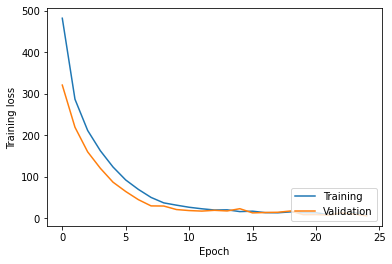

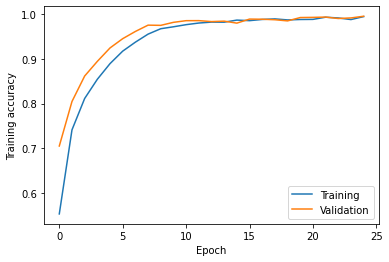

In [81]:
plt.figure(0)
plt.ylabel("Training loss")
plt.xlabel("Epoch")
plt.figure(1)
plt.ylabel("Training accuracy")
plt.xlabel("Epoch")


plt.figure(0)
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.legend(loc="lower right")

plt.figure(1)
plt.plot(train_accs, label="Training")
plt.plot(val_accs, label="Validation")
plt.legend(loc="lower right")

First layer filters


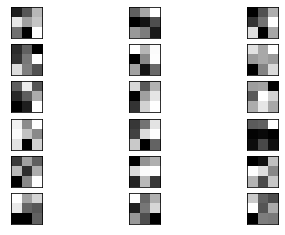

In [109]:
def print_filter(filters, n_filter_to_display=6):
    # Normalize 
    f_min, f_max = filters.max(), filters.min()
    filters = (filters - f_min) / (f_max - f_min)

    i_idx = 1
    for f_idx in range(n_filter_to_display):
        filter = filters[f_idx, :, :, :]
        for p_idx in range(3):
            ax = plt.subplot(n_filter_to_display, 3, i_idx)
            ax.set_xticks([])
            ax.set_yticks([])
            # Plot
            plt.imshow(filter[p_idx,:,:], cmap='gray')
            i_idx += 1
    plt.show()
    

print("First layer filters")
first_filters = model.get_first_conv_layer_filters()
print_filter(first_filters)

Last layer filters


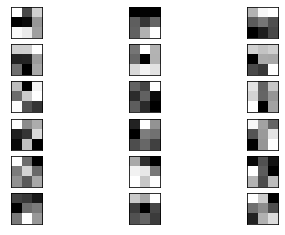

In [110]:
print("Last layer filters")
last_filters = model.get_last_conv_layer_filters()
print_filter(last_filters)

In [105]:
# For Q 3.6
if __name__ == "__main__":
  vis_image = None
  for data, labels in val_loader:
    vis_image = data[12].unsqueeze(0)
    break

In [ ]:
import pickle
vis_image = pickle.load(open("vis_image.pkl", "rb")).to(device)
plt.imshow(vis_image.squeeze().permute(1, 2, 0).cpu().detach().numpy())

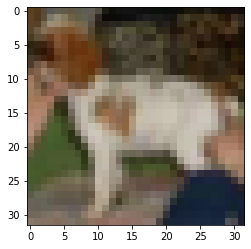

In [106]:
import matplotlib.pyplot as plt
plt.imshow(vis_image.squeeze().permute(1, 2, 0).cpu().detach().numpy())

### Display the feature map

In [108]:
vis_image.shape

torch.Size([1, 3, 32, 32])

In [113]:
first_filters.shape

(64, 3, 3, 3)

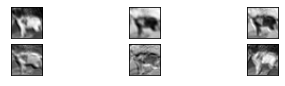

In [141]:
# Fin output size
nb_img, channel, dim_x_img, dim_y_img = vis_image.shape
dim_out = (dim_x_img-3)//1 + 1

""" This oculd be speed up with matrix multiplication ... """
# For each filter

output = np.zeros((64, dim_out, dim_out))

for filter_idx in range(first_filters.shape[0]):
    filter = first_filters[filter_idx]

    for channel_i in range(filter.shape[0]):
        # Apply kernel
        kernel = filter[channel_i]
        img = vis_image[0, channel_i].numpy()
        for i in range(0, dim_out):
            for j in range(0, dim_out):
                # Select part of the img
                img_patch = img[i:i+3, j:j+3]
                # Apply kernel
                kernel_output = np.multiply(img_patch, kernel)
                kernel_output = np.sum(kernel_output)
                # Save output
                output[filter_idx, i, j] = kernel_output

output.shape
plt.imshow(output[0])
i_idx = 1
nb_filter = 6 # output.shape[0]
for p_idx in range(nb_filter):
    ax = plt.subplot(nb_filter, 3, i_idx)
    ax.set_xticks([])
    ax.set_yticks([])
    # Plot
    plt.imshow(output[p_idx,:,:], cmap='gray')
    i_idx += 1
plt.show()